¿Es ergódica la cadena diferencial? True
¿Es ergódica la cadena lineal? True


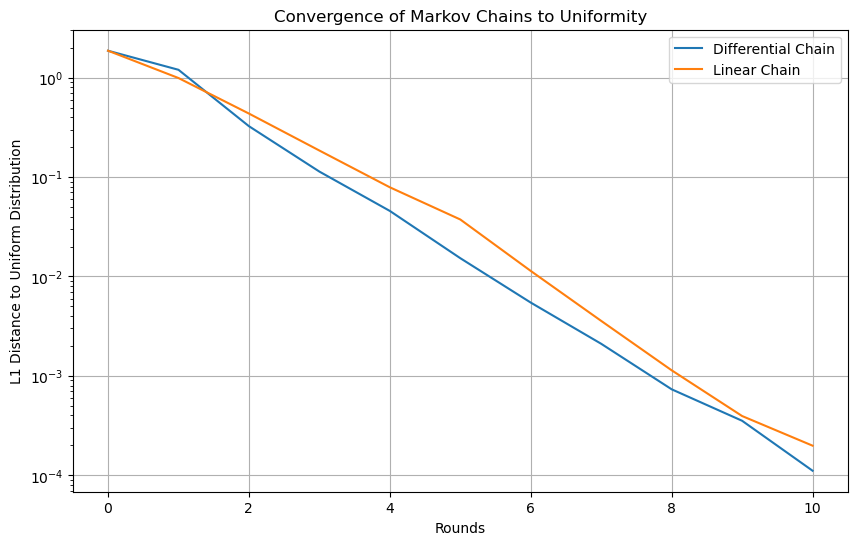

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def create_differential_transition_matrix(sbox):
    """Crea la matriz de transición para análisis diferencial"""
    n = len(bin(len(sbox)-1)[2:])  # Tamaño en bits de la S-box
    N = 2**n - 1  # Tamaño del espacio de estados (sin diferencia cero)
    
    P = np.zeros((N, N))
    
    for input_diff in range(1, N+1):
        for x in range(2**n):
            x_prime = x ^ input_diff
            if x_prime < 2**n:
                output_diff = sbox[x] ^ sbox[x_prime]
                if output_diff > 0:
                    P[input_diff-1, output_diff-1] += 1
    
    # Normalizar filas para hacer P estocástica
    for i in range(N):
        row_sum = np.sum(P[i])
        if row_sum > 0:
            P[i] /= row_sum
    
    return P

def create_linear_transition_matrix(sbox):
    # Crea la matriz de transición para análisis lineal
    n = len(bin(len(sbox)-1)[2:])
    N = 2**n - 1
    
    P = np.zeros((N, N))
    
    for input_mask in range(1, N+1):
        for output_mask in range(1, N+1):
            correlation = 0
            for x in range(2**n):
                input_parity = bin(x & input_mask).count('1') % 2
                output_parity = bin(sbox[x] & output_mask).count('1') % 2
                
                if input_parity == output_parity:
                    correlation += 1
                else:
                    correlation -= 1
            
            P[input_mask-1, output_mask-1] = (correlation / 2**n)**2
    
    return P

def analyze_markov_chain(P):
    # Analiza las propiedades de una cadena de Markov
    # Verificar si es doblemente estocástica
    is_doubly_stochastic = (np.allclose(np.sum(P, axis=0), 1) and 
                           np.allclose(np.sum(P, axis=1), 1))
    
    # Verificar ergodicidad de manera simple
    is_ergodic = np.all(np.linalg.matrix_power(P, P.shape[0]) > 0)
    
    # Analizar valores propios para tasa de convergencia
    eigenvalues = np.linalg.eigvals(P)
    sorted_eigs = sorted(abs(eigenvalues), reverse=True)
    
    convergence_rate = sorted_eigs[1] if len(sorted_eigs) > 1 else 0
    
    return {
        "is_doubly_stochastic": is_doubly_stochastic,
        "is_ergodic": is_ergodic,
        "convergence_rate": convergence_rate,
        "eigenvalues": sorted_eigs
    }

# Tu función ahora funcionará correctamente
def analyze_sbox_with_markov(sbox):

    # Create transition matrices
    diff_matrix = create_differential_transition_matrix(sbox)
    lin_matrix = create_linear_transition_matrix(sbox)
    
    # Analyze the Markov chains
    diff_analysis = analyze_markov_chain(diff_matrix)
    lin_analysis = analyze_markov_chain(lin_matrix)
    
    # Simulate the evolution of the chains
    rounds = 10
    initial_state = np.zeros(diff_matrix.shape[0])
    initial_state[0] = 1  # Start with a specific difference/mask
    
    diff_evolution = [initial_state]
    lin_evolution = [initial_state.copy()]
    
    for i in range(rounds):
        diff_evolution.append(diff_evolution[-1] @ diff_matrix)
        lin_evolution.append(lin_evolution[-1] @ lin_matrix)
    
    # Plot the convergence to uniformity
    uniform_dist = np.ones(diff_matrix.shape[0]) / diff_matrix.shape[0]
    
    diff_distances = [np.linalg.norm(dist - uniform_dist, 1) for dist in diff_evolution]
    lin_distances = [np.linalg.norm(dist - uniform_dist, 1) for dist in lin_evolution]
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(rounds+1), diff_distances, label='Differential Chain')
    plt.plot(range(rounds+1), lin_distances, label='Linear Chain')
    plt.xlabel('Rounds')
    plt.ylabel('L1 Distance to Uniform Distribution')
    plt.title('Convergence of Markov Chains to Uniformity')
    plt.legend()
    plt.yscale('log')
    plt.grid(True)
    
    return {
        "differential": diff_analysis,
        "linear": lin_analysis,
        "diff_matrix": diff_matrix,
        "lin_matrix": lin_matrix,
        "diff_evolution": diff_evolution,
        "lin_evolution": lin_evolution
    }





# S-box de ejemplo (4 bits)
sbox = [14, 4, 13, 1, 2, 15, 11, 8, 3, 10, 6, 12, 5, 9, 0, 7]

# Analizar la S-box
resultado = analyze_sbox_with_markov(sbox)

# Ver si las cadenas son ergódicas
print("¿Es ergódica la cadena diferencial?", resultado["differential"]["is_ergodic"])
print("¿Es ergódica la cadena lineal?", resultado["linear"]["is_ergodic"])